In [10]:
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 102
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


# 数据读取并可视化

In [11]:
df = pd.read_csv('../../data/data-0522.csv', dtype={'时间': str})

dates = [ f"{year}-{time.replace('.', '-')}" for year, time in zip(df['年份'], df['时间']) ]

data = df.iloc[1:, 1:-1].T
indices = data.index
data.index = pd.Series(range(0, len(indices)))

In [12]:
index = 0
print("选择的数据是：{}".format(indices[index]))

data_select = 1 # 进行数据集的选择

pre_ratio = 0.1

seq_length = 50

model_select = 0
# model_select = 1

num_epochs = 1500

lr_ratio = 1e-3

选择的数据是：上海新增确诊病例


1       0
2       0
3       0
4       0
5       0
       ..
806    96
807    82
808    88
809    84
810    52
Name: 0, Length: 810, dtype: int64

# 函数部分

对数据进行平滑处理

生成序列数据

In [13]:
def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# 画出要预测国家的每日新增图

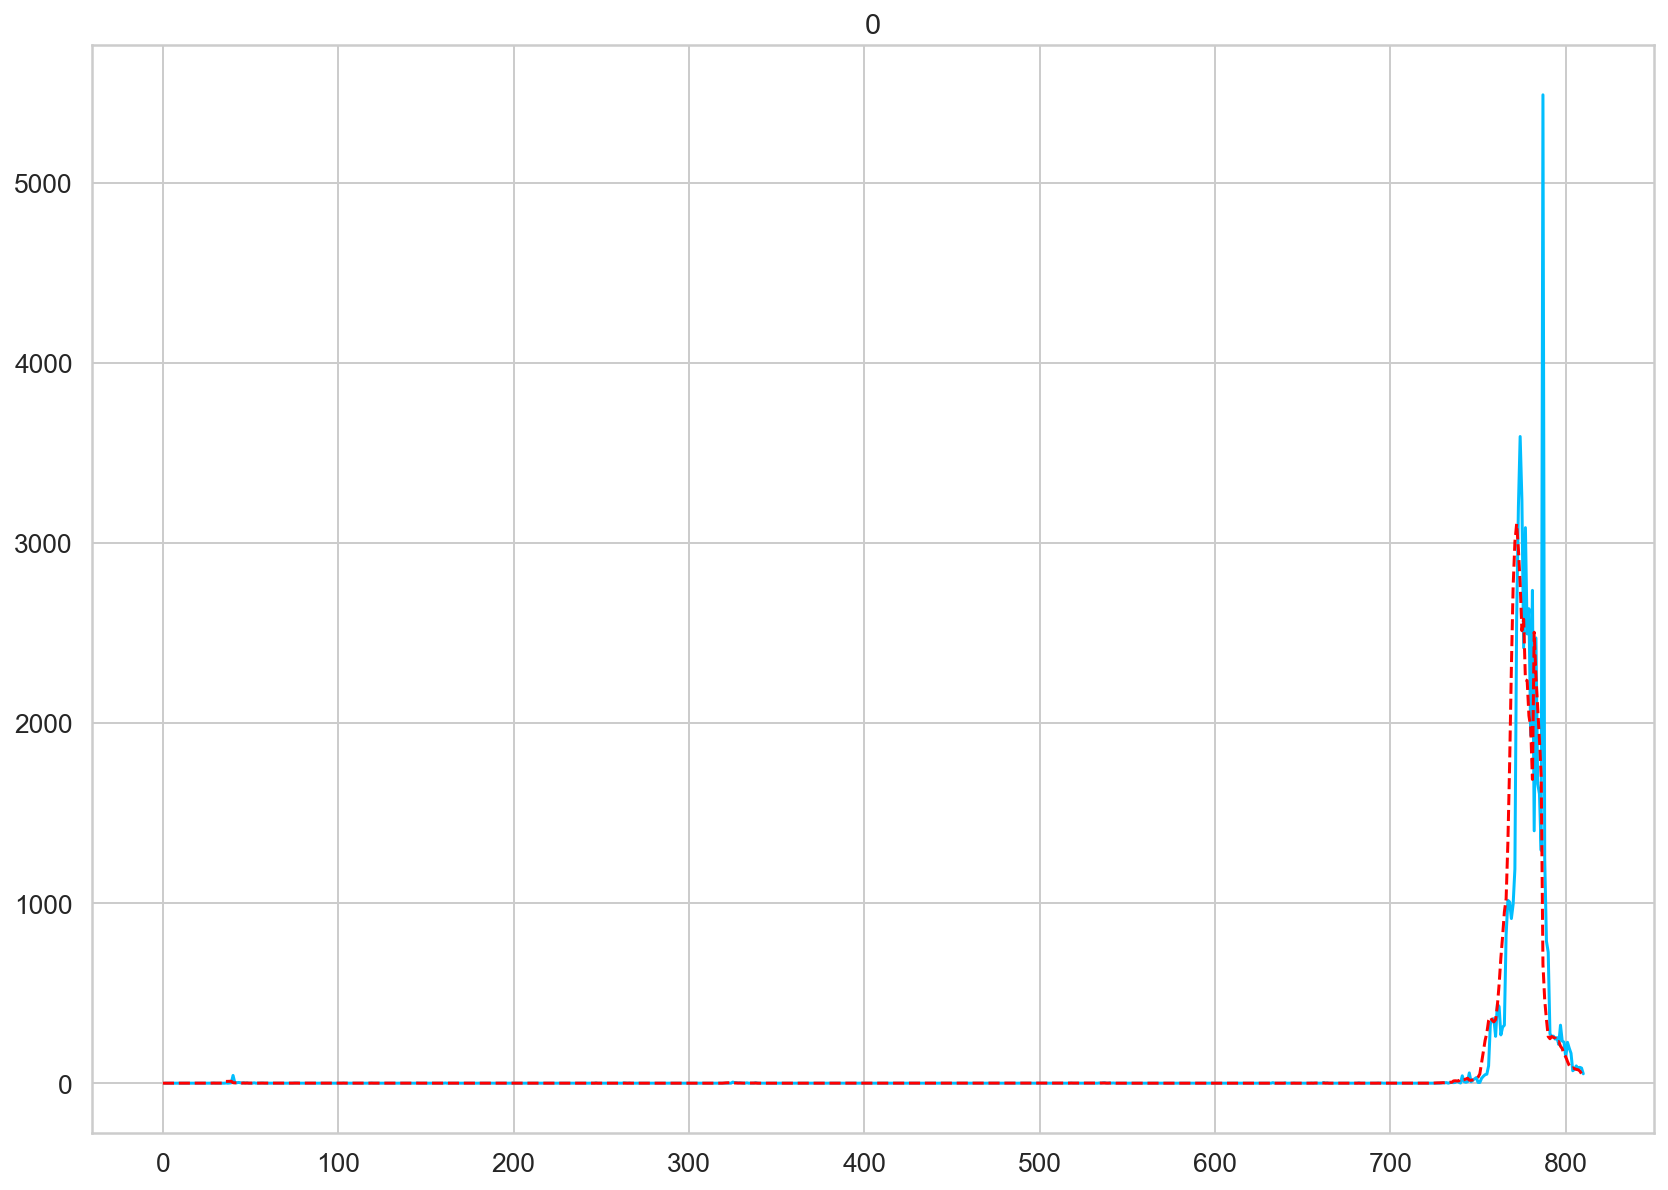

In [14]:
fig, ax = plt.subplots(1,1)
y1 = data.loc[index]
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
plt.plot(y1)
confirmed_avg = moving_average(y1, 5)
plt.plot(confirmed_avg, color='red', linestyle='dashed')
plt.title(index)

plt.show()

# 进行训练集、测试集划分

## 选择预测数据类型
每日新增、累计确诊和直线数据 三选一

In [15]:
if data_select == 0:
    chose_data = data.iloc[index].diff()[1:]
    chose_data = moving_average(chose_data, 5)
    print("选择单日新增")

elif data_select == 1:
    chose_data = data.iloc[index][1:]
    chose_data = moving_average(chose_data, 5)
    print("选择累计新增")

elif data_select == 2:
    chose_data = data.iloc[index][1:]
    chose_data = np.arange(1,1000,1)
    print("选择生成数据")

选择累计新增


## 对序列数据进行生成并归一化

In [16]:
test_data_size = int(data.shape[1] * pre_ratio)

scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(chose_data, axis=1))

chose_data = scaler.transform(np.expand_dims(chose_data, axis=1))


if model_select == 2:
    train_data = chose_data[:-test_data_size]
    test_data = chose_data[-test_data_size:]
    X_train = np.arange(len(train_data))
    y_train = train_data

    X_test = np.arange(len(train_data), len(train_data) + len(test_data))
    y_test = test_data

else:
    train_data = chose_data[:-test_data_size]
    test_data = chose_data[-test_data_size-seq_length:]
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)

## 转化成tensor

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 自动使用CPU或者GPU

X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# 模型构建
GRUNet和LSTM

In [18]:
class GRUNet(nn.Module):
 
    def __init__(self, input_size = 1):
        super(GRUNet, self).__init__()
        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=64,
            num_layers=3,
            batch_first=True,
            bidirectional=True,
            dropout = 0.1,
        )
        self.out = nn.Sequential(
            nn.Linear(128, 1)
        )
        self.avgpool =  nn.AdaptiveAvgPool2d((1,128))
        self.soft = nn.Softmax() 
        self.relu = nn.ReLU()

 
    def forward(self, x):
        r_out, h_n = self.rnn(x, None)  # None 表示 hidden state 会用全0的 state
        # print(r_out.unsqueeze(0).shape) # torch.Size([488, 15, 128]) torch.Size([215, 15, 128])
        # r_out = self.relu(r_out)
        out = self.avgpool(r_out.unsqueeze(0))
        # out = self.relu(out)
        # print(out.shape)
        # print(out.reshape(128,1).shape)
        out = out.squeeze(2).squeeze(0)
        out = self.out(out)
        out = self.relu(out)
        return out
 
 
class LSTMNet(nn.Module):
 
    def __init__(self, input_size = 1):
        super(LSTMNet, self).__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=64,
            num_layers=3,
            batch_first=True,
        )
        self.out = nn.Sequential(
            nn.Linear(128, 1)
        )
        self.relu = nn.ReLU()
        self.avgpool =  nn.AdaptiveAvgPool2d((1,128))
        self.soft = nn.Softmax() 
        self.dropout = nn.Dropout(p=0.05)
    def forward(self, x):
        # print(x.view(len(x), 10, -1).shape)
        r_out, (h_n, h_c) = self.rnn(x.view(len(x), seq_length, -1), None)  # None 表示 hidden state 会用全0的 state
        out = self.avgpool(r_out.unsqueeze(0))
        out = out.squeeze(2).squeeze(0)
        out = self.out(out)
        # out = self.dropout(out)
        out = self.relu(out)
        return out

class LinearModel(nn.Module):
 
    def __init__(self, seq_length = seq_length):
        super(LinearModel, self).__init__()
        self.tensor_in = nn.Sequential(
            nn.Linear(seq_length, 128)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(128, 256)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 512)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(512, 256)
        )
        self.out = nn.Sequential(
            nn.Linear(256, 1)
        )
        self.relu = nn.ReLU()
        self.soft = nn.Softmax() 
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.tensor_in(x)
        x = self.soft(x)
        x = self.layer2(x)
        out = self.relu(x)
        out = self.layer3(out)
        out = self.relu(out)
        out = self.layer4(out)
        out = self.relu(out)
        out = self.out(out)
        out = self.relu(out)
        return out
 

# 模型训练参数设置

In [19]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):

  loss_fn = torch.nn.MSELoss(reduction='sum') # 损失函数
  # loss_fn = torch.nn.L1Loss()
  # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr_ratio, betas=(0.9, 0.99)) # 优化器类型
  # scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=500, gamma = 0.8)
  if model_select != 2:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min= 0.0001)
  # torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False)

  
  

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)
  lr_list = []

  for t in range(num_epochs):
    y_pred = model(train_data)
    loss = loss_fn(y_pred.float(), train_labels)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(test_data)
        test_loss = loss_fn(y_test_pred.float(), test_labels)
      test_hist[t] = test_loss.item()

      if (t+1) % 100 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif (t+1) % 100 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
    if model_select != 2:
      scheduler.step()
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
  
  return model.eval(), train_hist, test_hist, lr_list

# 选择模型


In [20]:
if model_select == 0:
    model = LSTMNet()
    model_name = "LSTM"
elif model_select == 1:
    model = GRUNet()
    model_name = "GRUNet"
else:
    model = LinearModel(seq_length=1)
    model_name = "Linear"

# 模型训练
并输出loss变化曲线

Epoch 99 train loss: 7.099319645931246e-06 test loss: 11.913985252380371
Epoch 199 train loss: 7.099319645931246e-06 test loss: 11.913985252380371
Epoch 299 train loss: 7.099319645931246e-06 test loss: 11.913985252380371
Epoch 399 train loss: 7.099319645931246e-06 test loss: 11.913985252380371
Epoch 499 train loss: 7.099319645931246e-06 test loss: 11.913985252380371
Epoch 599 train loss: 7.099319645931246e-06 test loss: 11.913985252380371
Epoch 699 train loss: 7.099319645931246e-06 test loss: 11.913985252380371
Epoch 799 train loss: 7.099319645931246e-06 test loss: 11.913985252380371
Epoch 899 train loss: 7.099319645931246e-06 test loss: 11.913985252380371
Epoch 999 train loss: 7.099319645931246e-06 test loss: 11.913985252380371
Epoch 1099 train loss: 7.099319645931246e-06 test loss: 11.913985252380371
Epoch 1199 train loss: 7.099319645931246e-06 test loss: 11.913985252380371
Epoch 1299 train loss: 7.099319645931246e-06 test loss: 11.913985252380371
Epoch 1399 train loss: 7.09931964593

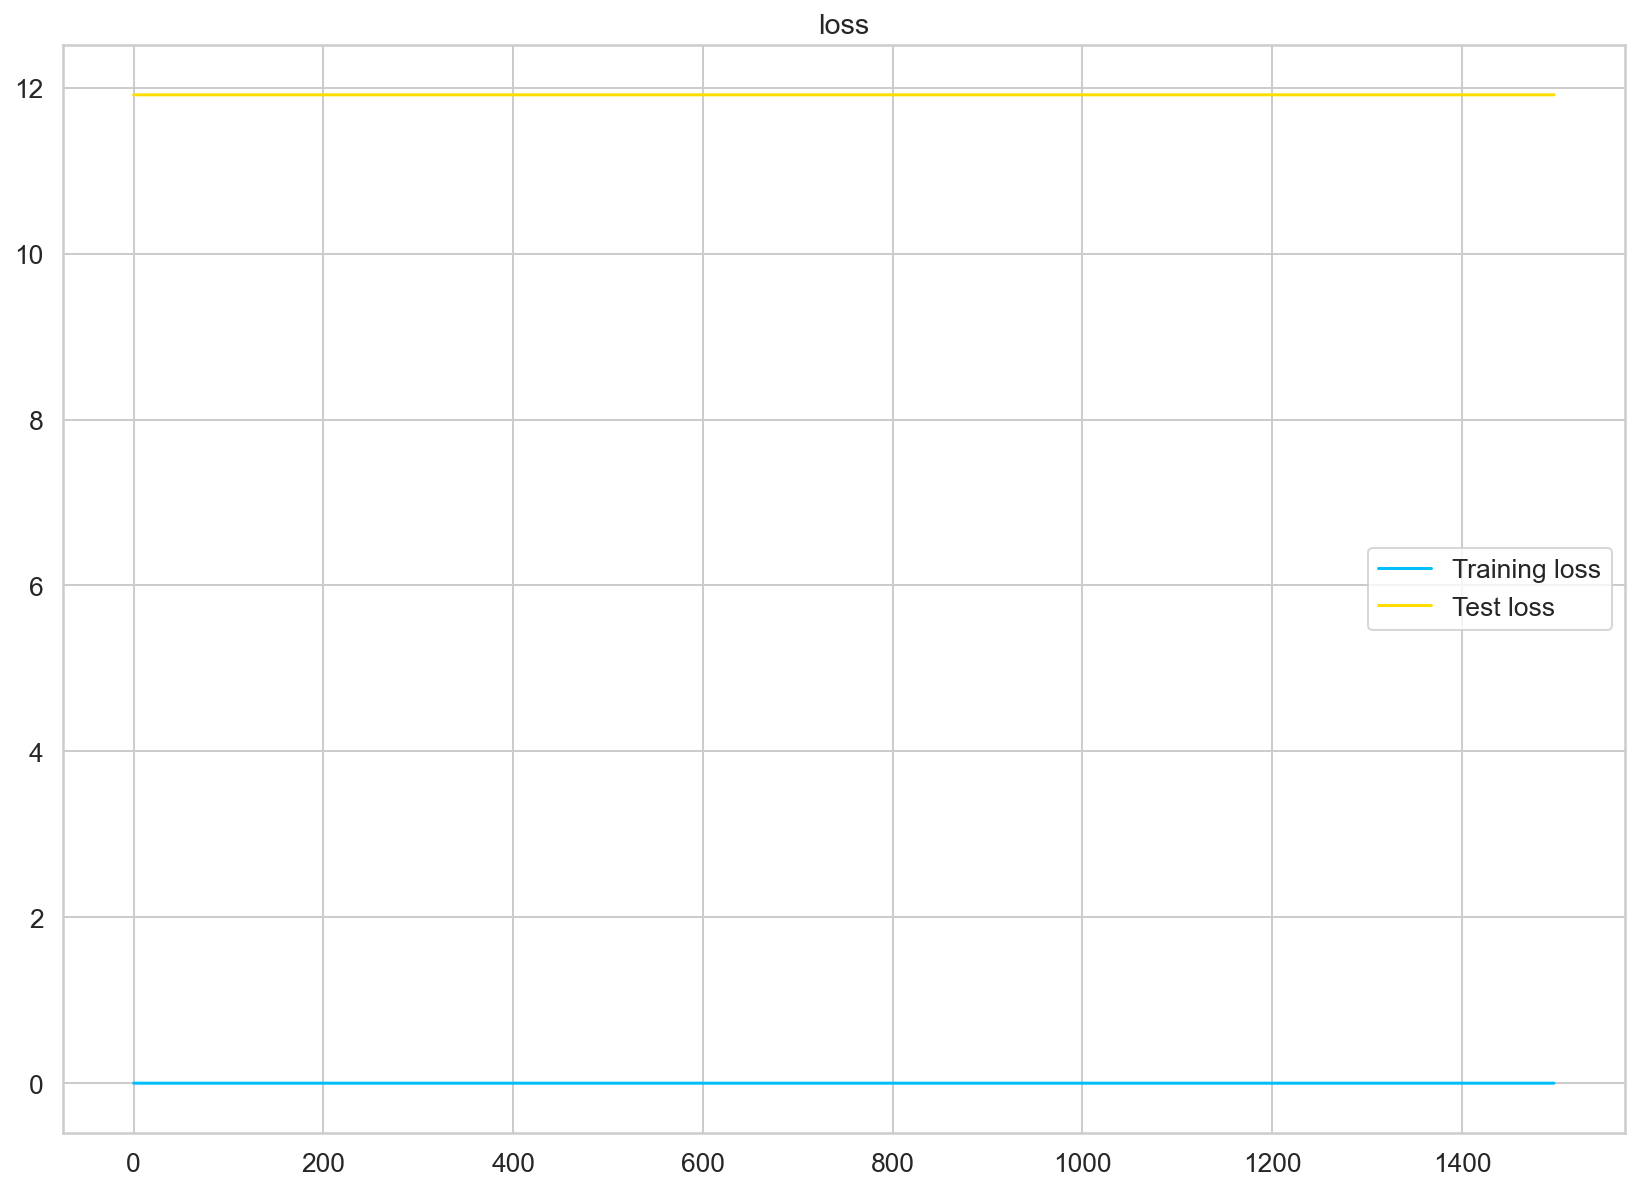

In [21]:
model = model.to(device)
model, train_hist, test_hist, lr_list = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

plt.plot(train_hist[2:], label="Training loss")
plt.plot(test_hist[2:], label="Test loss")
plt.title("loss")
plt.legend()

In [22]:
# '''载入数据'''
# from sklearn import datasets
# import numpy as np

# x = np.expand_dims(np.arange(len(chose_data)),1)
# y = np.expand_dims(chose_data, 1)
# '''引入标准化函数'''
# from sklearn import preprocessing
# x_MinMax = preprocessing.MinMaxScaler()
# y_MinMax = preprocessing.MinMaxScaler()
 
# ''' 将 y 转换成 列 '''


# y = np.array(y).reshape(len(y),1)
# '''标准化'''
# x = x_MinMax.fit_transform(x)
# y = y_MinMax.fit_transform(y)
 
# ''' 按二八原则划分训练集和测试集 '''
# from sklearn.model_selection import train_test_split
# np.random.seed(2019)

# x_train = x[:-int(len(x)*0.2)]
# x_test = x[-int(len(x)*0.2):]
# y_train = y[:-int(len(x)*0.2)]
# y_test = y[-int(len(x)*0.2):]
'''
x_train = X_train.unsqueeze(1).cpu()
x_test = X_test.unsqueeze(1).cpu()
y_train = y_train.cpu()
y_test = y_test.cpu()

# 模型构建
from sklearn.neural_network import MLPRegressor
fit1 = MLPRegressor(
        hidden_layer_sizes=(256, 64, 32), activation='logistic',solver='adam',
        alpha=0.01,max_iter=200)
print ("fitting model right now")
fit1.fit(x_train,y_train)
pred1_train = fit1.predict(x_train)
# 计算训练集 MSE
from sklearn.metrics import mean_squared_error
mse_1 = mean_squared_error(pred1_train,y_train)
print ("Train ERROR = ", mse_1)
# 计算测试集mse
preds = fit1.predict(np.expand_dims(np.arange(len(chose_data)), 1))
pred1 = fit1.predict(x_test)
# mse_2 = mean_squared_error(pred1_test,y_test)
# print ("Test ERROR = ", mse_2)
 
# 结果可视化
import matplotlib.pyplot as plt
xx=range(0,len(y_test))
plt.figure(figsize=(8,6))
plt.plot(xx,y_test,color="red",label="Sample Point",linewidth=3) 
plt.plot(xx,pred1,color="orange",label="Fitting Line",linewidth=2)
plt.legend()
plt.show()
'''

'\nx_train = X_train.unsqueeze(1).cpu()\nx_test = X_test.unsqueeze(1).cpu()\ny_train = y_train.cpu()\ny_test = y_test.cpu()\n\n# 模型构建\nfrom sklearn.neural_network import MLPRegressor\nfit1 = MLPRegressor(\n        hidden_layer_sizes=(256, 64, 32), activation=\'logistic\',solver=\'adam\',\n        alpha=0.01,max_iter=200)\nprint ("fitting model right now")\nfit1.fit(x_train,y_train)\npred1_train = fit1.predict(x_train)\n# 计算训练集 MSE\nfrom sklearn.metrics import mean_squared_error\nmse_1 = mean_squared_error(pred1_train,y_train)\nprint ("Train ERROR = ", mse_1)\n# 计算测试集mse\npreds = fit1.predict(np.expand_dims(np.arange(len(chose_data)), 1))\npred1 = fit1.predict(x_test)\n# mse_2 = mean_squared_error(pred1_test,y_test)\n# print ("Test ERROR = ", mse_2)\n \n# 结果可视化\nimport matplotlib.pyplot as plt\nxx=range(0,len(y_test))\nplt.figure(figsize=(8,6))\nplt.plot(xx,y_test,color="red",label="Sample Point",linewidth=3) \nplt.plot(xx,pred1,color="orange",label="Fitting Line",linewidth=2)\nplt.lege

## 学习率变化曲线

Text(0.5, 1.0, 'lr')

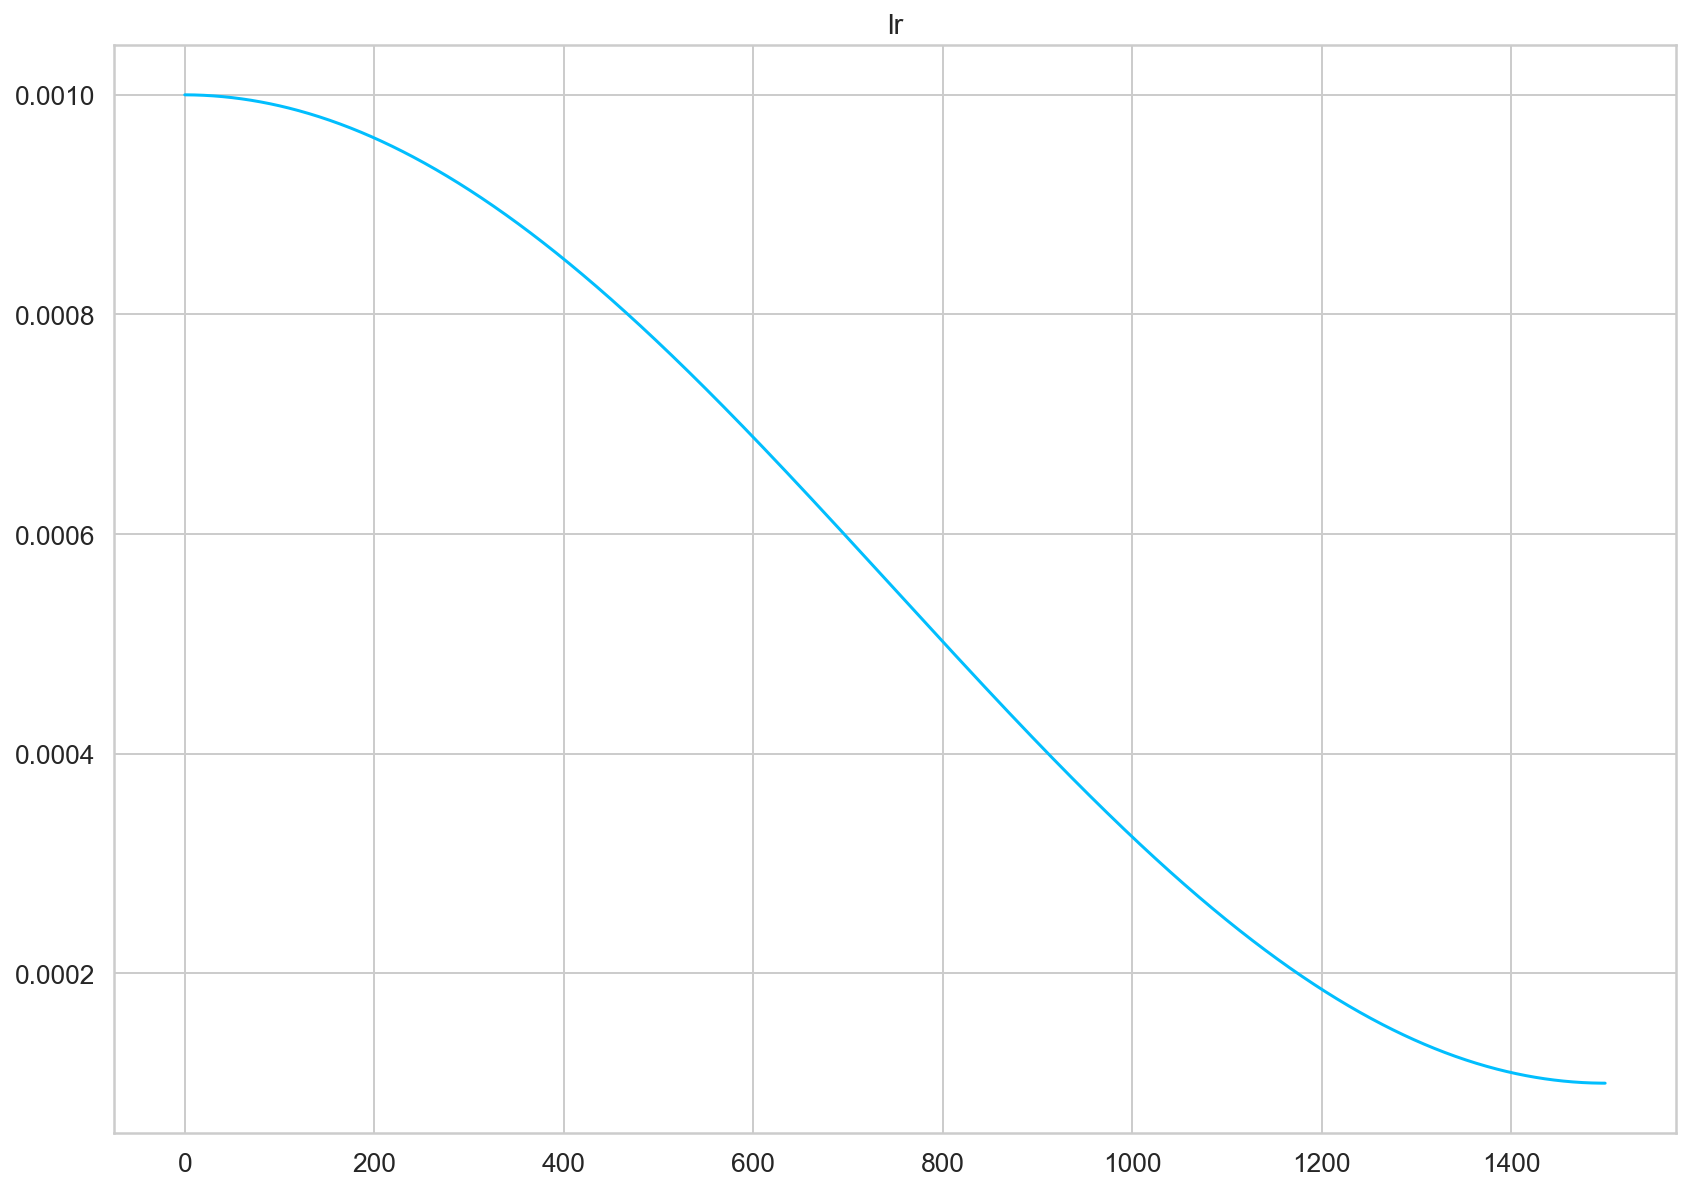

In [23]:
plt.plot(lr_list, label="lr")
plt.title("lr")

# 模型测试
## 模型测试

In [24]:
model = model.to(device)
with torch.no_grad():
  if model_select == 2:
    test_seq = X_test
    test_seq = test_seq.to(device)
    y_test_pred = model(test_seq)
    preds = y_test_pred.squeeze(1).cpu().numpy()
  else:
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
      test_seq = test_seq.to(device)
      y_test_pred = model(test_seq)
      pred = torch.flatten(y_test_pred).item()
      preds.append(pred)
      new_seq = test_seq.cpu().numpy().flatten()
      new_seq = np.append(new_seq, [pred])
      new_seq = new_seq[1:]
      test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

## 对国家疫情测试数据可视化

NameError: name 'country' is not defined

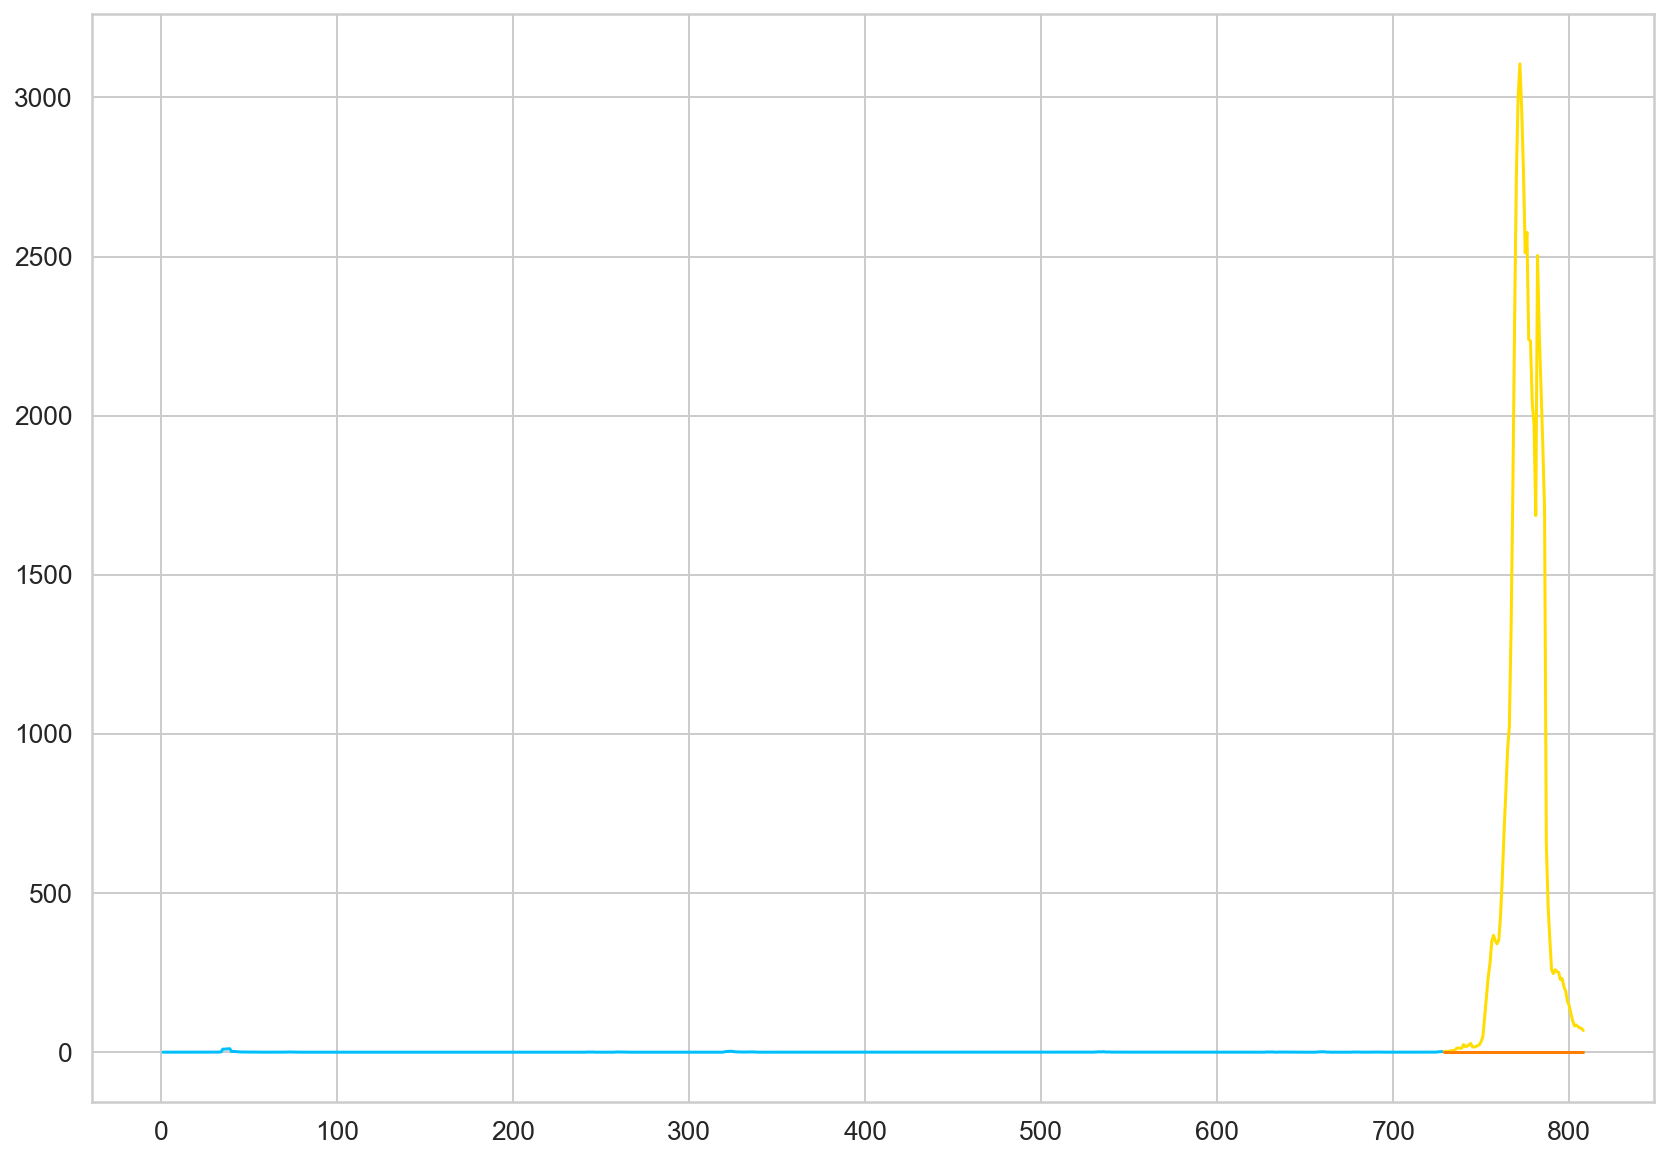

In [25]:
if model_select == 2 and data_select != 2:
  train_data = y_train.cpu()
  true_cases = scaler.inverse_transform(
      np.expand_dims(y_test.cpu().flatten().numpy(), axis=0)
  ).flatten()

  predicted_cases = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
  ).flatten()
  predicted_cases = np.int32(predicted_cases)

  fig, ax = plt.subplots(1,1)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

  plt.plot(
    data.iloc[index].index[:len(train_data)], 
    (scaler.inverse_transform(train_data).flatten()), # 648
    label='Historical Daily Cases'
  )
 
  print(data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)].shape)
  plt.plot(
    data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)],  # 721
    (true_cases), # 102
    label='Real Daily Cases'
  )

  # plt.plot(
  #   data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)], 
  #   (predicted_cases), 
  #   label='Predicted Daily Cases'
  # )
  plt.plot(
    data.iloc[index].index[:len(chose_data)], 
    (predicted_cases), 
    label='Predicted Daily Cases'
  )
  plt.title("model:{}  Country: {}".format(model_name, indices[index]))
  plt.legend()

elif data_select==0 or data_select==1:
  true_cases = scaler.inverse_transform(
      np.expand_dims(y_test.cpu().flatten().numpy(), axis=0)
  ).flatten()

  predicted_cases = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
  ).flatten()
  predicted_cases = np.int32(predicted_cases)

  fig, ax = plt.subplots(1,1)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(100))


  plt.plot(
    data.iloc[index].index[:len(train_data)], 
    (scaler.inverse_transform(train_data).flatten()),
    label='Historical Daily Cases'
  )

  plt.plot(
    data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)], 
    (true_cases),
    label='Real Daily Cases'
  )

  plt.plot(
    data.iloc[index].index[len(train_data):len(train_data) + len(true_cases)], 
    (predicted_cases), 
    label='Predicted Daily Cases'
  )
  plt.title("model:{}  Country: {}".format(model_name, indices[index]))
  plt.legend()
  print(np.sum(((true_cases - predicted_cases) / true_cases)**2))

## 对直线数据预测可视化

In [ ]:
if data_select == 2:
    true_cases = scaler.inverse_transform(
        np.expand_dims(y_test.cpu().flatten().numpy(), axis=0)
    ).flatten()

    predicted_cases = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
    ).flatten()
    predicted_cases = np.int32(predicted_cases)

    fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

    plt.plot(np.arange(0,len(train_data)), scaler.inverse_transform(train_data).flatten(), label = "Train")

    plt.plot(np.arange(len(train_data), len(train_data) + len(true_cases)), true_cases, label = "Real")

    plt.plot(np.arange(len(train_data), len(train_data) + len(predicted_cases)), predicted_cases, label = "predicted")

    plt.title("对直线数据进行拟合")